In [148]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import math
import open3d as o3d

In [149]:
def ray_plane_intersection(decoded_gray_image, camera_matrix, projector_matrix, rotation_matrix, translation_vector):
    # Make sure the translation vector is a column vector
    print("ray_plane_intersection")
    if translation_vector.ndim == 1 or translation_vector.shape[0] == 1:
        translation_vector = translation_vector.reshape(3, 1)
    height, width = decoded_gray_image.shape[:2]
    
    # Generate a grid of (u, v) coordinates
    u, v = np.meshgrid(np.arange(width), np.arange(height))
    u = u.flatten()
    v = v.flatten()
    proj_cols = decoded_gray_image.flatten()
    
    # Filter out invalid column indices
    valid_cols = proj_cols >= 0
    u_valid = u[valid_cols]
    v_valid = v[valid_cols]
    proj_cols_valid = proj_cols[valid_cols]
    
    # Normalize pixel coordinates to camera space
    camera_points_normalized = np.linalg.inv(camera_matrix).dot(
        np.vstack((u_valid, v_valid, np.ones_like(u_valid)))
    )
    
    # Projector points in homogeneous coordinates
    projector_points_homogeneous = np.vstack((proj_cols_valid, np.zeros_like(proj_cols_valid), np.ones_like(proj_cols_valid)))
    # Convert projector points to 3D space in camera coordinates
    projector_points_3D = np.linalg.inv(projector_matrix).dot(projector_points_homogeneous)
    projector_points_3D /= projector_points_3D[2, :]  # Normalize z to 1
    
    # Concatenate rotation matrix and translation vector to form the extrinsic matrix
    extrinsic_matrix = np.hstack((rotation_matrix, translation_vector))
    
    # Transform projector points to camera coordinate system
    projector_points_camera_coords = extrinsic_matrix.dot(
        np.vstack((projector_points_3D[:3, :], np.ones(projector_points_3D.shape[1])))
    )
    # Assuming the planes are perpendicular to the projector's y-axis
    plane_normal_projector = np.array([0, 1, 0])  # Normal along Y-axis for vertical stripes
    plane_normal_camera = rotation_matrix.dot(plane_normal_projector)
    # Ray directions for each camera point
    ray_directions = camera_points_normalized[:3, :] - np.zeros((3, 1))  # Camera origin is (0, 0, 0)

    # Calculate ray-plane intersections
    dot_normals = plane_normal_camera.T.dot(ray_directions)
    valid_rays = dot_normals != 0  # Avoid division by zero
    # Calculating intersection 't' for each ray
    t = np.zeros(dot_normals.shape)
    t[valid_rays] = (plane_normal_camera.T.dot(projector_points_camera_coords[:3, :] - translation_vector)) / dot_normals[valid_rays]

    # Intersection points in camera coordinates
    intersection_points = ray_directions * t + np.zeros((3, 1))  # Adding camera origin
    # Prepare the output array
    points_3D = np.zeros((height * width, 3))
    points_3D[valid_cols, :] = intersection_points.T  # Transpose to match the shape
    points_3D = points_3D.reshape((height, width, 3))
    
    return points_3D

In [150]:
def undistortPoints(src,dst,cameraMatrix,distCoeffs):
    """
    :param src: Input Distorted Image.
    :param dst: Output Corrected image with same size and type as src.
    :param CameraMatrix: Intrinsic camera Matrix K
    :param distCoeffs: distortion coefficients (k1,k2,p1,p2,[k3]) of 4,5, or 8 elements.
    :return: undistorted image.
    """
    image = cv.undistort(src,dst,cameraMatrix,distCoeffs)
    return image

In [151]:
def visualize_point_cloud(points_3D):
    print("visualize_point_cloud")
    points = points_3D.reshape(-1, 3) # Convert points from 3D matrix to list of 3D coordinates
    points = points[np.any(points != [0, 0, 0], axis=1)] # Filter out zero points
    
    print("open3d")
    # Convert the points to an open3d point cloud object
    point_cloud = o3d.geometry.PointCloud()
    print("pc generated")
    point_cloud.points = o3d.utility.Vector3dVector(points)
    print("points generated")
    
    o3d.visualization.draw_geometries_with_editing([point_cloud])

    
# def createMesh(points,radius=1.0,iterations=100,confidence=0.9): ##Might want to use open3D instead
#     """
#         :param points: 3D points
#         :param radius: Optional, default=1
#         :param iterations: Optional, default=100
#         :param confidence: Optional, default=0.9
#     """
#     # Compute the normals for the point cloud
#     normals = cv.computeNormals(points)
#     # Create the surface mesh
#     mesh = cv.surfaceReconstruction(points, normals, radius, iterations, confidence)

In [152]:
def visualizeTest(points_3D):
    # Create a random point cloud for demonstration
    points = points_3D.reshape(-1, 3) # Convert points from 3D matrix to list of 3D coordinates
    print(points.shape)
    points = points[np.any(points != [0, 0, 0], axis=1)] # Filter out zero points

    # Convert the points to an open3d point cloud object
    point_cloud = o3d.geometry.PointCloud()
    print("pc generated")
    point_cloud.points = o3d.utility.Vector3dVector(points)

    # Create a set of coordinate axes with a larger size
    axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0, 0, 0])

    # Combine the point cloud and the axes into a list of geometries
    geometries = [point_cloud, axes]

    # Visualize the combined geometries
    o3d.visualization.draw_geometries(geometries)

    
# def createMesh(points,radius=1.0,iterations=100,confidence=0.9): ##Might want to use open3D instead
#     """
#         :param points: 3D points
#         :param radius: Optional, default=1
#         :param iterations: Optional, default=100
#         :param confidence: Optional, default=0.9
#     """
#     # Compute the normals for the point cloud
#     normals = cv.computeNormals(points)
#     # Create the surface mesh
#     mesh = cv.surfaceReconstruction(points, normals, radius, iterations, confidence)

In [153]:
def generate_gray_code_patterns(width, height):
    """
    :param width: Projector Width
    :param Height: Projector Height
    """
    # Calculate number of bits required to represent the width
    num_bits = math.ceil(math.log2(width))
    # Calculate the offset to center the pattern
    offset = (2 ** num_bits - width) // 2

    # Initialize pattern storage
    pattern = np.zeros((height, width, num_bits), dtype=np.uint8)
    directory = "C:\\Users\\nludw\\Documents\\Capstone\\Binary Coding\\GrayCodedPictures"  # Change to Pi directory
    # Generate binary and Gray code numbers
    binary_numbers = np.array([list(format(i, '0' + str(num_bits) + 'b')) for i in range(2 ** num_bits)], dtype=np.uint8)
    gray_codes = np.bitwise_xor(binary_numbers[:, :-1], binary_numbers[:, 1:]) #XOR bitwise for gray coding
    gray_codes = np.c_[binary_numbers[:, 0], gray_codes]  # Add the first bit back
    
    # Fill in the pattern
    for i in range(num_bits):
        pattern[:, :, i] = np.tile(gray_codes[(np.arange(width) + offset), i].reshape(1, -1), (height, 1))
        filename = "gray_pattern{}.png".format(i)
        cv.imwrite(directory + "\\" + filename, 255*pattern[:,:,i]) #Need to multiply by 255 for openCV to save as white
    blankImage = np.zeros((height,width), dtype=np.uint8)
    fullImage = 255*np.ones((height,width),dtype=np.uint8)
    cv.imwrite(directory + "\\blankImage.png", blankImage)
    cv.imwrite(directory + "\\fullImage.png", fullImage)
        
    return pattern, offset

In [154]:
def convert_gray_code_to_decimal(gray_code_patterns):
    print("convert to gray code")
    height, width, num_bits = gray_code_patterns.shape
    # num_bits -= 1 ### DELETE THIS AFTER TESTING
    binary_patterns = np.zeros((height, width, num_bits), dtype=np.uint8)
    binary_patterns[:, :, 0] = gray_code_patterns[:, :, 0]
    for i in range(1, num_bits):
        binary_patterns[:, :, i] = np.bitwise_xor(binary_patterns[:, :, i-1], gray_code_patterns[:, :, i])
        
    decimal_values = np.zeros((height, width), dtype=int)
    for i in range(num_bits):
        decimal_values += (2 ** (num_bits - 1 - i)) * binary_patterns[:, :, i]
    decimal_values += 1
    decimal_values -= int(64) # adjust decimal values according to aspect ratio to get columns 1 through 1920 (should be 64 for 1920 by 1080, 224 for 1600 by 1200). 
    return decimal_values 

In [155]:
def pbpthreshold(image,threshold):
    """
    :param image: Input image.
    :param threshold: Threshold image.
    """
    #Compares image to thresholding image, set binary, if < than threshold image pixel = 0, if >, pixel goes to 255.
    flatimage = image.flatten()
    flatthreshold = threshold.flatten()
    if len(image) != len(threshold):
        print("Image and Threshold Matrix are incompatible sizes")
        return
    for i in range(len(flatimage)):
        if flatimage[i] <= flatthreshold[i]:
            flatimage[i] = 0
        elif flatimage[i] > flatthreshold[i]:
            flatimage[i] = 255
            
    image = flatimage.reshape(image.shape)
    return image

In [156]:
width = 1920
height = 1080
grayPattern, offsets = generate_gray_code_patterns(width, height)
blankImage = cv.imread("blank_image.png") #to convert from 0-255 to 0-1
fullImage = cv.imread("full_image.png")
blankImage = blankImage.astype(np.float32)
fullImage = fullImage.astype(np.float32)
print(blankImage[500][100])
blankImage = cv.cvtColor(blankImage, cv.COLOR_BGR2GRAY)
fullImage = cv.cvtColor(fullImage,cv.COLOR_BGR2GRAY)
print(blankImage[500][100])
image_array = np.empty((grayPattern.shape[2],fullImage.shape[0],fullImage.shape[1]), dtype=grayPattern.dtype)
avg_thresh = cv.addWeighted(blankImage,0.5,fullImage,0.5,0) #add white and blank images for thresholding and average
# cv.divide(avg_thresh, 2)


[105. 105. 108.]
105.897


In [157]:

# # Viewing the patterns
# cv.imshow('Pattern', grayPattern[:,:,3] * 255)
# cv.waitKey(0)
# cv.destroyAllWindows()

In [158]:
for i in range(grayPattern.shape[2]-1):

    # load image array and pre-process images
    filein = "image_{}.png".format(i+1)
    image = cv.imread(filein)
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    print(avg_thresh)
    #Convert to black and white based on grascale (average per pixel thresholding)
    # cv.imshow('image', image_gray)
    # cv.waitKey(0)
    image_thresh = pbpthreshold(image_gray,avg_thresh)
    # cv.imshow('thresh', image_thresh)
    # cv.waitKey(0)
    # cv.destroyAllWindows()
    image_array[i] = image_thresh
    captured_patterns = np.transpose(image_array,(1,2,0)) #reorder shape for binary decoding 

# print(captured_patterns)

[[25.682    42.28     80.8725   ... 75.6045   76.6315   75.508995]
 [79.0735   75.723    71.965004 ... 76.5475   76.0745   75.7455  ]
 [76.29401  75.524994 72.555    ... 75.6045   75.4605   75.5175  ]
 ...
 [59.6175   58.468    59.612    ... 53.291504 52.5905   53.332497]
 [58.7045   58.848503 59.313004 ... 53.234497 52.297    51.919502]
 [59.734497 59.498    59.1635   ... 53.2915   51.998    51.27    ]]
[[25.682    42.28     80.8725   ... 75.6045   76.6315   75.508995]
 [79.0735   75.723    71.965004 ... 76.5475   76.0745   75.7455  ]
 [76.29401  75.524994 72.555    ... 75.6045   75.4605   75.5175  ]
 ...
 [59.6175   58.468    59.612    ... 53.291504 52.5905   53.332497]
 [58.7045   58.848503 59.313004 ... 53.234497 52.297    51.919502]
 [59.734497 59.498    59.1635   ... 53.2915   51.998    51.27    ]]
[[25.682    42.28     80.8725   ... 75.6045   76.6315   75.508995]
 [79.0735   75.723    71.965004 ... 76.5475   76.0745   75.7455  ]
 [76.29401  75.524994 72.555    ... 75.6045   75.4

In [159]:
col_values = convert_gray_code_to_decimal(captured_patterns)
col_values = convert_gray_code_to_decimal(grayPattern)
decoded_image = convert_gray_code_to_decimal(captured_patterns)

#Chnaged values
# K = np.array([[1642.17076,0,1176.14705],[0, 1642.83775, 714.90826],[0,0,1]])
# R = np.array([[1,0,0],[0,1,0],[0,0,1]])
# t = np.array([[0],[0],[1]])
# P_proj = np.array([[1642.17076,0,0],[0,1642.83775,0],[0,0,1]])

coeiff = np.load('calib.npz')
lst = coeiff.files
R = coeiff['R']
t = coeiff['T']
P_proj = coeiff['proj_matrix']
K = coeiff['cam_matrix']
# K = np.array([[1315.17076,0,795.14705],[0, 1320.8212, 587.90826],[0,0,1]])
# R = np.array([[.92,.029,-.38],[-.088,0.986,-.13],[.379,.160,.912]])
# t = np.array([[151.996],[-55.6],[296.37]])
# P_proj = np.array([[1315.45,0,795],[0,1320.83775,587.33],[0,0,1]])

# points_3D = ray_plane_intersection(decoded_image,K,P_proj,R,t)
# print(points_3D)


convert to gray code
convert to gray code
convert to gray code


In [160]:
decoded_gray_image, camera_matrix, projector_matrix, rotation_matrix, translation_vector = decoded_image,K,P_proj,R,t


In [161]:
print("ray_plane_intersection")
if translation_vector.ndim == 1 or translation_vector.shape[0] == 1:
    translation_vector = translation_vector.reshape(3, 1)
height, width = decoded_gray_image.shape[:2]
print(height, width)

ray_plane_intersection
1080 1920


In [162]:
 # Generate a grid of (u, v) coordinates

u, v = np.meshgrid(np.arange(width), np.arange(height))
u = u.flatten()
v = v.flatten()
proj_cols = decoded_gray_image.flatten()
# Filter out invalid column indices
valid_cols = proj_cols >= 0
u_valid = u[valid_cols]
v_valid = v[valid_cols]
proj_cols_valid = proj_cols[valid_cols]
# Normalize pixel coordinates to camera space
camera_points_normalized = np.linalg.inv(camera_matrix).dot(
    np.vstack((u_valid, v_valid, np.ones_like(u_valid)))
)
print(camera_points_normalized)

[[-0.51266102 -0.51196598  0.54379847 ... -0.06922605 -0.06853101
   0.5479687 ]
 [-0.26626756 -0.26626756 -0.06088141 ...  0.49267646  0.49267646
   0.49267646]
 [ 1.          1.          1.         ...  1.          1.
   1.        ]]


In [163]:
# Projector points in homogeneous coordinates
projector_points_homogeneous = np.vstack((proj_cols_valid, np.zeros_like(proj_cols_valid), np.ones_like(proj_cols_valid)))
# Convert projector points to 3D space in camera coordinates
projector_points_3D = np.linalg.inv(projector_matrix).dot(projector_points_homogeneous)
projector_points_3D /= projector_points_3D[2, :]  # Normalize z to 1
print(projector_points_homogeneous)
# Concatenate rotation matrix and translation vector to form the extrinsic matrix



[[130710 131025 132034 ...  67010  67010  67010]
 [     0      0      0 ...      0      0      0]
 [     1      1      1 ...      1      1      1]]


In [164]:
 # Transform projector points to camera coordinate system
projector_points_camera_coords = extrinsic_matrix.dot(
    np.vstack((projector_points_3D[:3, :], np.ones(projector_points_3D.shape[1])))
)
# Assuming the planes are perpendicular to the projector's y-axis
plane_normal_projector = np.array([0, 1, 0])  # Normal along Y-axis for vertical stripes
plane_normal_camera = rotation_matrix.dot(plane_normal_projector)
# Ray directions for each camera point
print(camera_points_normalized[0])
ray_directions = camera_points_normalized[:3, :] - np.zeros((3, 1))  # Camera origin is (0, 0, 0)


[-0.51266102 -0.51196598  0.54379847 ... -0.06922605 -0.06853101
  0.5479687 ]


In [174]:
#TEST
principal_point_x = camera_matrix[0,2]
principal_point_y = camera_matrix[1,2]
optical_center_3d = np.linalg.inv(camera_matrix) @ np.array([principal_point_x, principal_point_y, 1])
print(optical_center_3d)
ray_directions = camera_points_normalized[:3, :] - optical_center_3d.reshape((3, 1))


[0. 0. 1.]


In [166]:
# Calculate ray-plane intersections

dot_normals = plane_normal_camera.T.dot(ray_directions)

valid_rays = abs(dot_normals) > 1e-10 # Avoid division by zero
# Calculating intersection 't' for each ray
t = np.zeros(dot_normals.shape)
t[valid_rays] = (plane_normal_camera.T.dot(projector_points_camera_coords[:3, :] - translation_vector)) / dot_normals[valid_rays]

In [167]:
# Intersection points in camera coordinates
print(ray_directions)
intersection_points = ray_directions * t + np.zeros((3, 1))  # Adding camera origin
# Prepare the output array
points_3D = np.zeros((height * width, 3))
points_3D[valid_cols, :] = intersection_points.T  # Transpose to match the shape
points_3D = points_3D.reshape((height, width, 3))

[[-0.51266102 -0.51196598  0.54379847 ... -0.06922605 -0.06853101
   0.5479687 ]
 [-0.26626756 -0.26626756 -0.06088141 ...  0.49267646  0.49267646
   0.49267646]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [168]:
points = points_3D.reshape(-1, 3)
points = points[np.any(points != [0, 0, 0], axis=1)]
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points)


threshold = 0
col = points[:,1]
above_threshold_count = np.sum(col > threshold)
below_threshold_count = np.sum(col < threshold)

total_count = col.size
above_threshold_percentage = (above_threshold_count / total_count) * 100
below_threshold_percentage = (below_threshold_count / total_count) * 100

# Print the percentages
print(f"Percentage of values above {threshold}: {above_threshold_percentage:.2f}%")
print(f"Percentage of values below {threshold}: {below_threshold_percentage:.2f}%")

print(points_3D[:,2].shape)
# o3d.visualization.draw_geometries([point_cloud])

Percentage of values above 0: 75.49%
Percentage of values below 0: 24.51%
(1080, 3)


In [169]:
visualizeTest(points_3D)

(2073600, 3)
pc generated


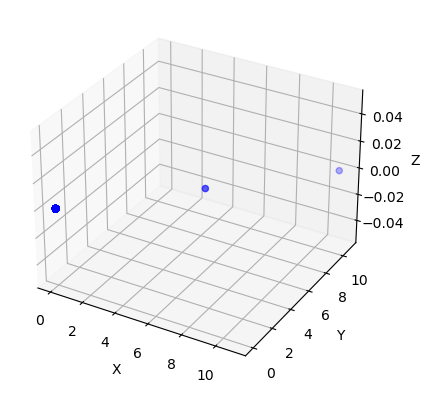

In [170]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3D[:, 0], points_3D[:, 1], points_3D[:, 2], c='b', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()